In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import matplotlib.colors as colors
%matplotlib inline

In [2]:
from pyquil.quil import Program, MEASURE
from pyquil.api import SyncConnection, JobConnection
from pyquil.job_results import wait_for_job
from pyquil.gates import CZ, H, I, X

In [3]:
# TODO delete me before merging!
cxn = SyncConnection(endpoint="http://localhost:5000")

In [4]:
def append_damping_to_gate(gate, damp_prob=.1):
    """
    Generate the Kraus operators corresponding to a given unitary 
    single qubit gate followed by an amplitude damping noise channel.
    
    :params np.ndarray|list gate: The 2x2 unitary gate matrix.
    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    damping_op = np.sqrt(damp_prob) * np.array([[0, 1],
                                                [0, 0]])
    
    residual_kraus = np.sqrt(np.eye(2) - damping_op.T.conjugate().dot(damping_op))
    return [residual_kraus.dot(gate), damping_op.dot(gate)]

In [5]:
%%time
cxn = SyncConnection(endpoint="http://localhost:5000")
# cxn = JobConnection(endpoint="http://localhost:5000")

damping_per_I = 0.02
trials = 200

results = []
outcomes = []
lengths = np.arange(0, 201, 10, dtype=int)
for num_I in lengths:
    print("Simulating for num_I={}".format(num_I))
    
    p = Program(X(0))
    # want increasing number of I-gates
    p.inst([I(0) for _ in range(num_I)])
    p.inst(MEASURE(0, [0]))
    
    # overload identity I on qc 0
    p.define_noisy_gate("I", [0], append_damping_to_gate(np.eye(2), damping_per_I))
    cxn.random_seed = int(num_I)
    res = cxn.run(p, [0], trials=trials)
    results.append([np.mean(res), np.std(res) / np.sqrt(trials)])
    
results = np.array(results)

Simulating for num_I=0
Simulating for num_I=10
Simulating for num_I=20
Simulating for num_I=30
Simulating for num_I=40
Simulating for num_I=50
Simulating for num_I=60
Simulating for num_I=70
Simulating for num_I=80
Simulating for num_I=90
Simulating for num_I=100
Simulating for num_I=110
Simulating for num_I=120
Simulating for num_I=130
Simulating for num_I=140
Simulating for num_I=150
Simulating for num_I=160
Simulating for num_I=170
Simulating for num_I=180
Simulating for num_I=190
Simulating for num_I=200
CPU times: user 94 ms, sys: 15.1 ms, total: 109 ms
Wall time: 1min 41s


In [6]:
dense_lengths = np.arange(lengths.max()+1)
survival_probs = (1-damping_per_I)**dense_lengths
logpmf = binom.logpmf(np.arange(trials+1)[np.newaxis, :], trials, survival_probs[:, np.newaxis])/np.log(10)

In [7]:
DARK_TEAL = '#48737F'
FUSCHIA = "#D6619E"
BEIGE = '#EAE8C6'
cm = colors.LinearSegmentedColormap.from_list('anglemap', ["white", FUSCHIA, BEIGE], N=256, gamma=1.5)

(0, 1)

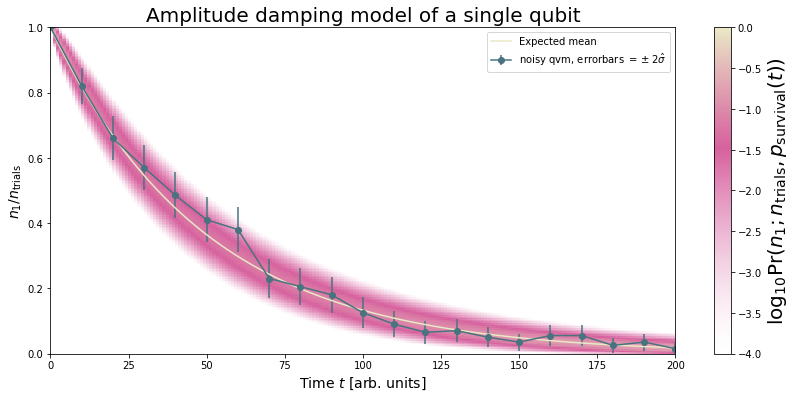

In [8]:
plt.figure(figsize=(14, 6))
plt.pcolor(dense_lengths, np.arange(trials+1)/trials, logpmf.T, cmap=cm, vmin=-4, vmax=logpmf.max())
plt.plot(dense_lengths, survival_probs, c=BEIGE, label="Expected mean")
plt.errorbar(lengths, results[:,0], yerr=2*results[:,1], c=DARK_TEAL, 
             label=r"noisy qvm, errorbars $ = \pm 2\hat{\sigma}$", marker="o")
cb = plt.colorbar()
cb.set_label(r"$\log_{10} \mathrm{Pr}(n_1; n_{\rm trials}, p_{\rm survival}(t))$", size=20)

plt.title("Amplitude damping model of a single qubit", size=20)
plt.xlabel(r"Time $t$ [arb. units]", size=14)
plt.ylabel(r"$n_1/n_{\rm trials}$", size=14)
plt.legend(loc="best")
plt.xlim(*lengths[[0, -1]])
plt.ylim(0, 1)